# Visualizing the SpaceX Tesla Roadster trip to Mars

In [1]:
from astropy.time import Time
from astropy import units as u

from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.frames import Planes
from poliastro.plotting import OrbitPlotter3D
from poliastro.util import time_range

EPOCH = Time("2018-02-18 12:00:00", scale="tdb")

In [2]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [3]:
roadster = Ephem.from_horizons(
    "SpaceX Roadster",
    epochs=time_range(EPOCH, end=EPOCH + 360 * u.day),
    attractor=Sun,
    plane=Planes.EARTH_ECLIPTIC,
    id_type="majorbody",
)
roadster

In [4]:
from poliastro.plotting.misc import plot_solar_system

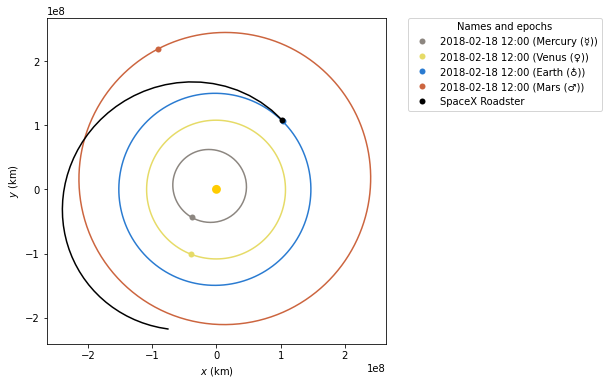

In [5]:
frame = plot_solar_system(outer=False, epoch=EPOCH)
frame.plot_ephem(roadster, EPOCH, label="SpaceX Roadster", color="black");

In [6]:
frame = OrbitPlotter3D(plane=Planes.EARTH_ECLIPTIC)

frame.plot_body_orbit(Earth, EPOCH)
frame.plot_body_orbit(Mars, EPOCH)

frame.plot_ephem(roadster, EPOCH, label="SpaceX Roadster", color="black")

frame.set_view(45 * u.deg, -120 * u.deg, 4 * u.km)